# Running ABC models
This notebook shows how to run an Izhikevich neuron model which is implemented in SpineML.

It depends on an installation of SpineCreator. If you don't have one, you can find out how here: http://bimpa.group.shef.ac.uk/SpineML/index.php/SpineCreator_-_A_Graphical_Tool#Building_on_Linux

We make system calls to execute the SpineML model (with SpineML_2_BRAHMS) and then we load the resulting output and visualise it here with matplotlib.

## Set paths
First, we need to tell this notebook where to find the SpineML model.

In [19]:
# Path to the directory in which the Izhikevich model is stored:
modeldir_global = '/home/seb/izhibg/IzhikevichABC/Izhi_STN'
# Path to your SpineML_2_BRAHMS installation:
spineml2brahms_global = '/home/seb/src/SpineML_2_BRAHMS'

## Set parameters

Set up some default abc parameters for the model:

In [2]:
# Here are the default model parameters
_a=0.03; _b=0.193; _c=-65; _d=0.05;
_vpeak=30; _A=0.032; _B=4; _C=113.147; _T=0.4; _SI=5;
_vinit=-70; _uinit=-10;

## Modify then run and visualise an ABC model

Define a function to run the model:

In [6]:
# *Modify* the model then run it and finally analyse it.
def define_and_run_model (constI=0, a=_a, b=_b, c=_c, d=_d, 
                          vpeak=_vpeak, A=_A, B=_B, C=_C, T=_T, SI=_SI,
                          lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10, 
                          qpspacing=3, qpveclen=60, vinit=_vinit, uinit=_uinit):

    # Where's the model and data?
    modeldir = modeldir_global;
    expt = 0;
    spineml2brahms = spineml2brahms_global;
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' -cSebtest1:I:'+`constI`+' ; popd"';
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+'Sebtest1_v_log.bin');
    u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+'Sebtest1_u_log.bin');

    import numpy as np

    # Compute nullclines
    I = np.zeros(v_count)+constI;
    Vn = np.linspace (lowerV, upperV, 1000);
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)]/SI;
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)]/SI;
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)

## Run the model with interact

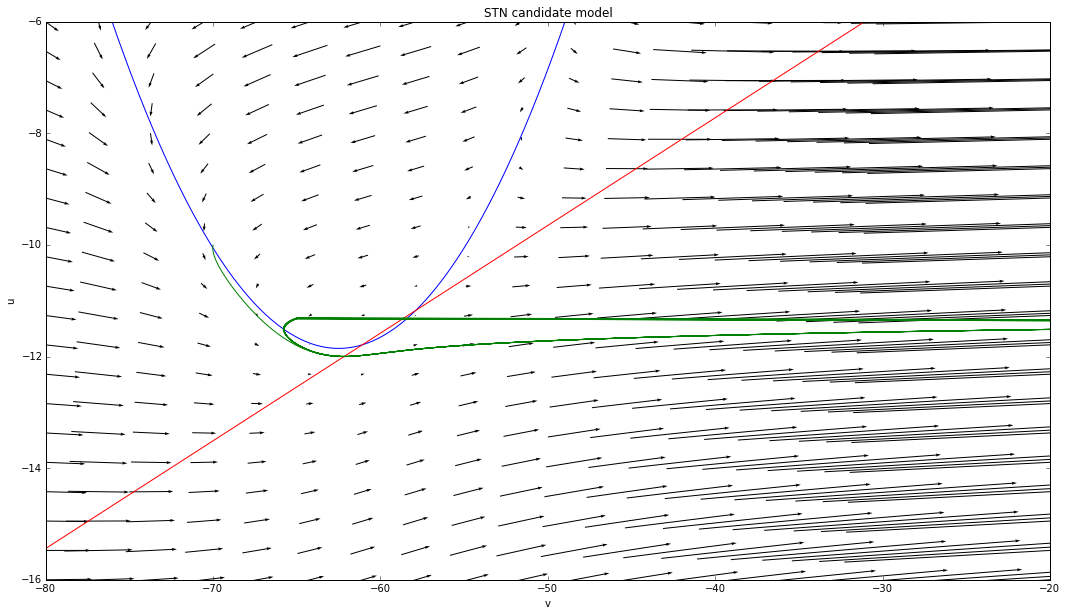

In [8]:
from IPython.html.widgets import interact

interact(define_and_run_model,
         constI=(-100,100,0.5),
         a=(0.02,0.035,0.0001),
         b=(0.100,0.300,0.001),
         c=(-120,30,1),
         d=(0,0.5,0.01),
         T=(0.0,10.0,0.1),
         A=(0.03,0.035,0.0001),
         B=(3,5,0.01),
         C=(100,150,0.1),
         vpeak=(20,40,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpscale=(0,6,0.1),
         qpdivisor=(0.00001,0.0001,0.00001),
         vinit=(-120,30,.1),
         uinit=(-20,10,.1));

Here're the equations for the above:
$$\dot{v} = A v^2 + B v + C -u + I$$
$$\dot{u} = a (bv-u)$$

## Read, run and visualise an ABC model

In [11]:
# *Read* the model then run it and finally analyse it.
def run_model (expt=0, lowerV=-80, upperV=-20, qvloweru=-16, qvupperu=-10,
               qpspacing=3, qpveclen=70):

    # Where's the model and data?
    modeldir = modeldir_global;
    spineml2brahms = spineml2brahms_global;
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import read_abc_model_xml as abcread
    a,b,c,d,A,B,C,T,vpeak,vinit,uinit = abcread.read_abc_model_xml (modeldir,expt)

    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
                 `expt`+' ; popd"'; # omit: +' -cSebtest1:I:'+`constI`
    os.system(spinemlcmd);

    # load the data from the model run
    import load_sc_data as lsd
    v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+'Sebtest1_v_log.bin');
    u, u_count, tu, nnu, dt = lsd.load_sc_data (spinemltmp+'Sebtest1_u_log.bin');

    import numpy as np

    # Temporary hack - better to get this from xml
    constI = 0
    
    # Compute nullclines
    Vn = np.linspace (lowerV, upperV, 1000);
    I = np.zeros(v_count)+constI;
    nc_v = A*np.power(Vn, 2)+ B*Vn + C + I[:len(Vn)];
    nc_u = Vn*b;

    # Compute vector field
    if qpspacing != 0:
        thescale = abs(lowerV-upperV)/qpspacing;
        Vgv = np.linspace(lowerV, upperV, thescale);
        ugv = np.linspace(qvloweru, qvupperu, thescale);
        Vg, ug = np.meshgrid(Vgv, ugv);
        vdot = T*A*Vg*Vg + T*B*Vg + T*C - T*ug + T*I[:len(Vg)];
        udot = T*a*(b*Vg - ug);
    
    # Plot it.
    %matplotlib inline
    import plot_izhi as pizhi
    pizhi.plot_izhi ('STN candidate model', v, u, Vn, nc_v, nc_u, Vg, ug, vdot, udot,
                     lowerV, upperV, qvloweru, qvupperu, qpspacing, qpveclen)
    
    # Now plot the time series
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18,10))
    plt.clf;
    plt.plot (t, v)
    plt.xlabel('t (ms)')
    plt.ylabel('v') 

<function __main__.run_model>

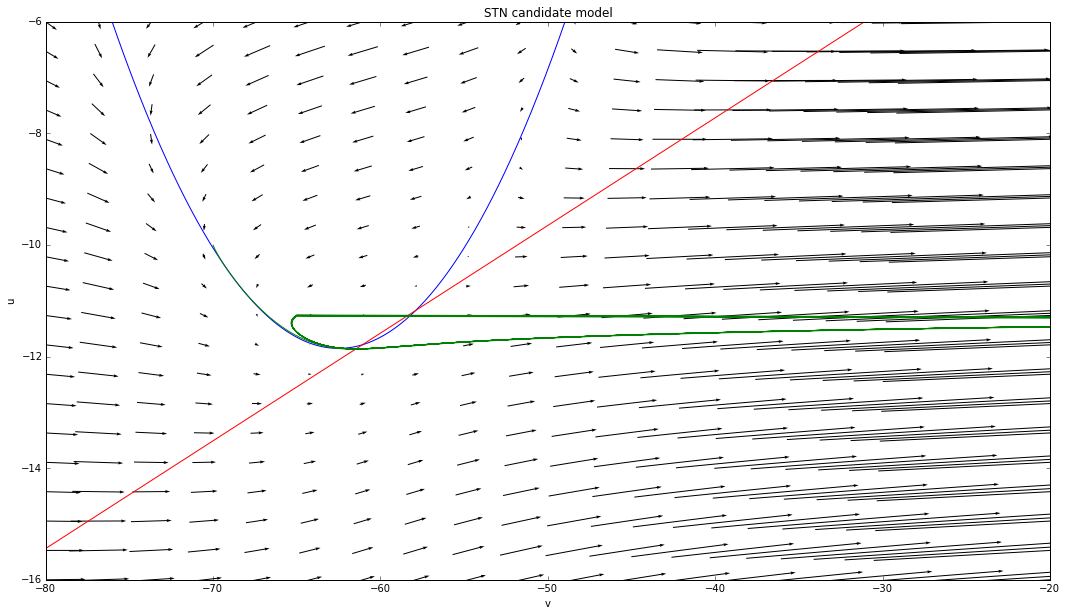

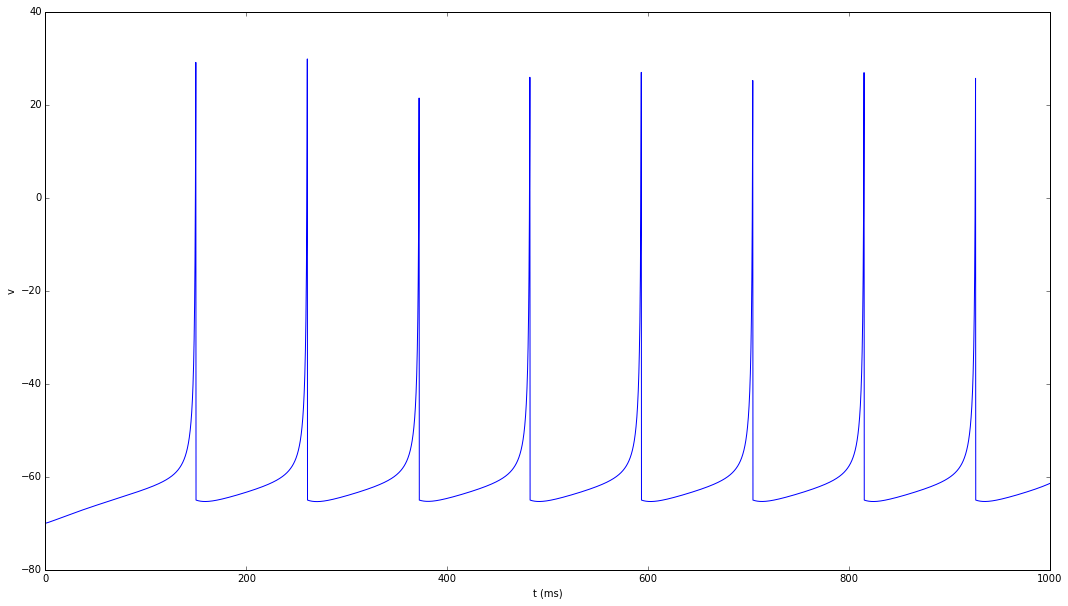

In [12]:
from IPython.html.widgets import interact

interact(run_model,
         expt=(0,10,1),
         lowerV=(-120,-40,1),
         upperV=(-40,60,1),
         qvloweru=(-20,0,1),
         qvupperu=(-6,10,1),
         qpspacing=(0,10,0.5),
         qpveclen=(10,300,10))

## Produce firing rate vs. current for ABC model

In [17]:
# Do a sweep through the currents with a given set of parameters.
def rate_sweep (constIlist):
    # Set your parameters here...
    expt = 0;
    a=_a; b=_b; c=_c; d=_d
    vpeak=_vpeak;
    A=_A; B=_B; C=_C; T=_T; SI=_SI;
    lowerV=-80; upperV=-20; qvloweru=-16; qvupperu=-10
    qpscale=3; qpdivisor=0.00001;
    vinit=_vinit; uinit=_uinit
    # Where's the model and data?
    modeldir = modeldir_global;
    spineml2brahms = spineml2brahms_global;
    spinemltmp = spineml2brahms+'/temp/log/';

    # Modify the model xml
    import update_abc_model_xml as abcupdate
    abcupdate.update_abc_model_xml (modeldir,expt,a,b,c,d,A,B,C,T,SI,vpeak,vinit,uinit)

    # Execute the model
    import os
    import load_sc_data as lsd
    import firing_rate as fr

    # Put this in a loop, and do some analysis to extract the firing rate from the output.
    rates=[];
    isiRates=[];
    for constI in constIlist:
        spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+`expt`+' -cSebtest1:I:'+`constI`+' ; popd"';
        os.system(spinemlcmd);

        # load the data from the model run
        v, v_count, t, nn, dt = lsd.load_sc_data (spinemltmp+'Sebtest1_v_log.bin');
        u, u_count, tu, nnu, dtu = lsd.load_sc_data (spinemltmp+'Sebtest1_u_log.bin');
    
        rate, isiRate = fr.firing_rate (v, t[len(t)-1], 0.1)
        print 'rate:', rate, ' isiRate:', isiRate
        rates.append(rate);
        isiRates.append(isiRate);

    return rates, isiRates


rate: 6.00060006001  isiRate: 6.5970313359
rate: 6.00060006001  isiRate: 6.80272108844
rate: 7.00070007001  isiRate: 7.24487683709
rate: 8.00080008001  isiRate: 8.64584459094
rate: 12.00120012  isiRate: 12.8383438536
rate: 30.0030003  isiRate: 30.2969097152
rate: 76.0076007601  isiRate: 76.8841679312
rate: 186.01860186  isiRate: 190.106295993
rate: 280.0280028  isiRate: 288.659793814


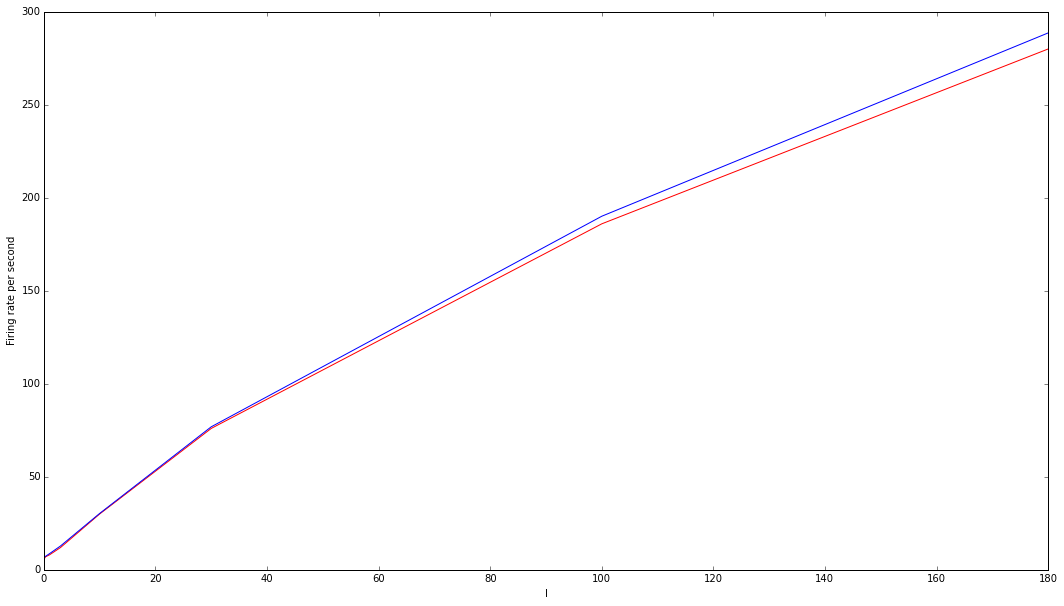

In [18]:
constIlist = [0, 0.1, 0.3, 1, 3, 10, 30, 100, 180]
rates, isiRates = rate_sweep(constIlist)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.clf;
plt.plot (constIlist, rates, color='r')
plt.plot (constIlist, isiRates, color='b')
plt.xlabel('I')
plt.ylabel('Firing rate per second')